<a href="https://colab.research.google.com/github/almalkiashwaq0/SA-Legal-Judgment-Prediction/blob/main/Documents_Aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install evaluate

In [ ]:
import re
import torch.nn as nn
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, DataCollatorWithPadding, BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from joblib import Parallel, delayed, parallel_config
import gc
import json
from tqdm.auto import tqdm
import evaluate
import plotly.graph_objects as go
import matplotlib.ticker as mtick

In [ ]:
model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

## Aggregation logits

In [ ]:
def classify_documents_with_methods(data, model, tokenizer, max_len, device):
    document_outputs = {}
    model.to(device)
    model.eval()

    for doc_id, group in data.groupby("Document_ID"):
        sentence_logits = []
        segment_lengths = []
        segment_confidences = []

        for _, row in group.iterrows():
            inputs = tokenizer(
                row["Segmented_Facts"],
                max_length=max_len,
                padding=True,
                truncation=True,
                return_tensors="pt"
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs["logits"].cpu().numpy()[0]
                sentence_logits.append(logits)


                segment_lengths.append(len(row["Segmented_Facts"].split()))
                probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
                segment_confidences.append(np.max(probs))

        sentence_logits = np.vstack(sentence_logits)
        segment_lengths = np.array(segment_lengths)
        segment_confidences = np.array(segment_confidences)
        num_segments = len(sentence_logits)

        def normalize(w): return w / (np.sum(w) + 1e-8)

        weighted_logits = {
            "length_weighted": np.average(sentence_logits, axis=0, weights=normalize(segment_lengths)),
            "confidence_weighted": np.average(sentence_logits, axis=0, weights=normalize(segment_confidences)),
            "positional_early": np.average(sentence_logits, axis=0, weights=normalize(np.linspace(1.0, 0.1, num_segments))),
            "positional_late": np.average(sentence_logits, axis=0, weights=normalize(np.linspace(0.1, 1.0, num_segments)))
        }

        if num_segments > 3:
            top3_indices = np.argsort(segment_confidences)[-3:]
            top3_logits = sentence_logits[top3_indices]
            top3_mean = np.mean(top3_logits, axis=0)
        else:
            top3_mean = np.mean(sentence_logits, axis=0)

        aggregated_logits = {
            "max": np.max(sentence_logits, axis=0),
            "mean": np.mean(sentence_logits, axis=0),
            "median": np.median(sentence_logits, axis=0),
            "top3_mean": top3_mean,
            **weighted_logits
        }

        document_outputs[doc_id] = {
            method: {
                "probs": torch.softmax(torch.tensor(logits), dim=-1).numpy(),
                "pred": int(torch.argmax(torch.tensor(logits))),
                "confidence": float(torch.softmax(torch.tensor(logits), dim=-1)[1].item())
            }
            for method, logits in aggregated_logits.items()
       }


        document_outputs[doc_id]["Reconstructed_Fact"] = " ".join(group["Segmented_Facts"].tolist())
        document_outputs[doc_id]["Encoded_Label"] = group["Encoded_Label"].iloc[0]
        document_outputs[doc_id]["Type"] = group["Type"].iloc[0]
        document_outputs[doc_id]["Num_Segments"] = int(group["Sentence_Rank"].max())

    return document_outputs



def export_predictions_to_csv(document_outputs, output_file="document_predictions.csv"):
    methods = [k for k in next(iter(document_outputs.values())).keys() if isinstance(document_outputs[next(iter(document_outputs))][k], dict)]

    records = []
    for doc_id, outputs in document_outputs.items():
        row = {
            "Document_ID": doc_id,
            "Reconstructed_Fact": outputs["Reconstructed_Fact"],
            "Type": outputs["Type"],
            "Encoded_Label": outputs["Encoded_Label"],
            "Num_Segments": outputs["Num_Segments"]
        }

        for method in methods:
            row[f"Predicted_Label_{method}"] = outputs[method]["pred"]
            row[f"Confidence_{method}"] = outputs[method]["confidence"]

        records.append(row)

    df = pd.DataFrame(records)
    df.to_csv(output_file, index=False)
    print(f"CSV saved to: {output_file}")
    return df

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_doc_outputs = classify_documents_with_methods(test_texts, model, tokenizer, max_len=512, device=device)
test_df_result = export_predictions_to_csv(test_doc_outputs, output_file="test_predictions.csv")


val_doc_outputs = classify_documents_with_methods(val_texts, model, tokenizer, max_len=512, device=device)
val_df_result = export_predictions_to_csv(val_doc_outputs, output_file="val_predictions.csv")


train_doc_outputs = classify_documents_with_methods(train_texts, model, tokenizer, max_len=512, device=device)
train_df_result = export_predictions_to_csv(train_doc_outputs, output_file="train_predictions.csv")


CSV saved to: test_predictions.csv
CSV saved to: val_predictions.csv
CSV saved to: train_predictions.csv


In [ ]:
def evaluate_document_outputs(df, methods, dataset_name="Dataset"):
    y_true = df["Encoded_Label"]
    method_results = {}

    print(f"\n====================== {dataset_name.upper()} EVALUATION ======================")

    for method in methods:
        y_pred = df[f"Predicted_Label_{method}"]
        y_score = df[f"Confidence_{method}"]

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="weighted")
        precision = precision_score(y_true, y_pred, average="weighted")
        recall = recall_score(y_true, y_pred, average="weighted")
        try:
            roc = roc_auc_score(y_true, y_score)
        except ValueError:
            roc = None

        cm = confusion_matrix(y_true, y_pred)

        method_results[method] = {
            "accuracy": acc,
            "f1_score": f1,
            "precision": precision,
            "recall": recall,
            "roc_auc": roc,
            "confusion_matrix": cm
        }

        print(f"\n {method} Aggregation:")
        print(f"Accuracy:        {acc:.2f}")
        print(f"F1 Score:        {f1:.2f}")
        print(f"Precision:       {precision:.2f}")
        print(f"Recall:          {recall:.2f}")
        print(f"ROC AUC:         {roc if roc is not None else 'N/A'}")
        print("Confusion Matrix:")
        print(cm)

    return method_results

In [ ]:
test_results = evaluate_document_outputs(test_df_result, methods, dataset_name="Test")

for method, result in test_results.items():
    plot_confusion_matrix(result["confusion_matrix"], class_names, "Test", method)


val_results = evaluate_document_outputs(val_df_result, methods, dataset_name="Validation")
for method, result in val_results.items():
    plot_confusion_matrix(result["confusion_matrix"], class_names, "Validation", method)


train_results = evaluate_document_outputs(train_df_result, methods, dataset_name="Training")
for method, result in train_results.items():
    plot_confusion_matrix(result["confusion_matrix"], class_names, "Training", method)



====================== TEST EVALUATION ======================

 max Aggregation:
Accuracy:        0.85
F1 Score:        0.85
Precision:       0.85
Recall:          0.85
ROC AUC:         0.9320589796316114
Confusion Matrix:
[[1768  215]
 [ 370 1612]]

 mean Aggregation:
Accuracy:        0.85
F1 Score:        0.85
Precision:       0.86
Recall:          0.85
ROC AUC:         0.9322350473474583
Confusion Matrix:
[[1755  228]
 [ 352 1630]]

 median Aggregation:
Accuracy:        0.85
F1 Score:        0.85
Precision:       0.85
Recall:          0.85
ROC AUC:         0.9282376486716302
Confusion Matrix:
[[1743  240]
 [ 355 1627]]

 top3_mean Aggregation:
Accuracy:        0.85
F1 Score:        0.85
Precision:       0.86
Recall:          0.85
ROC AUC:         0.9299459126083313
Confusion Matrix:
[[1754  229]
 [ 349 1633]]

 length_weighted Aggregation:
Accuracy:        0.84
F1 Score:        0.84
Precision:       0.84
Recall:          0.84
ROC AUC:         0.9227275179082749
Confusion Matrix:
[[


====================== VALIDATION EVALUATION ======================

 max Aggregation:
Accuracy:        0.86
F1 Score:        0.86
Precision:       0.86
Recall:          0.86
ROC AUC:         0.9363951043891301
Confusion Matrix:
[[1405  181]
 [ 278 1308]]

 mean Aggregation:
Accuracy:        0.86
F1 Score:        0.86
Precision:       0.86
Recall:          0.86
ROC AUC:         0.935325889044906
Confusion Matrix:
[[1404  182]
 [ 267 1319]]

 median Aggregation:
Accuracy:        0.86
F1 Score:        0.86
Precision:       0.86
Recall:          0.86
ROC AUC:         0.9311853879071128
Confusion Matrix:
[[1393  193]
 [ 266 1320]]

 top3_mean Aggregation:
Accuracy:        0.86
F1 Score:        0.86
Precision:       0.86
Recall:          0.86
ROC AUC:         0.9327674449669158
Confusion Matrix:
[[1401  185]
 [ 265 1321]]

 length_weighted Aggregation:
Accuracy:        0.85
F1 Score:        0.85
Precision:       0.85
Recall:          0.85
ROC AUC:         0.9292618339219749
Confusion Matri


====================== TRAINING EVALUATION ======================

 max Aggregation:
Accuracy:        0.92
F1 Score:        0.92
Precision:       0.93
Recall:          0.92
ROC AUC:         0.9782902936627176
Confusion Matrix:
[[5985  357]
 [ 597 5746]]

 mean Aggregation:
Accuracy:        0.93
F1 Score:        0.93
Precision:       0.93
Recall:          0.93
ROC AUC:         0.9791049393165925
Confusion Matrix:
[[6010  332]
 [ 561 5782]]

 median Aggregation:
Accuracy:        0.93
F1 Score:        0.93
Precision:       0.93
Recall:          0.93
ROC AUC:         0.9777329483609964
Confusion Matrix:
[[5978  364]
 [ 575 5768]]

 top3_mean Aggregation:
Accuracy:        0.93
F1 Score:        0.93
Precision:       0.93
Recall:          0.93
ROC AUC:         0.979110420667991
Confusion Matrix:
[[6013  329]
 [ 560 5783]]

 length_weighted Aggregation:
Accuracy:        0.92
F1 Score:        0.92
Precision:       0.92
Recall:          0.92
ROC AUC:         0.9742589275056103
Confusion Matrix:

In [ ]:
methods = ["mean", "max", "median", "top3_mean",
           "length_weighted", "confidence_weighted",
           "positional_early", "positional_late"]


fig = go.Figure()

for method in methods:
    col_name = f"Confidence_{method}"


    if col_name not in test_df_result.columns:
        test_df_result[col_name] = test_df_result["Document_ID"].map(
            lambda x: test_doc_preds[x][method]["confidence"]
            if isinstance(test_doc_preds[x][method], dict) else np.nan
        )


    valid_rows = test_df_result[col_name].notna()
    y_true = test_df_result.loc[valid_rows, "Encoded_Label"]
    y_score = test_df_result.loc[valid_rows, col_name]


    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)


    fig.add_trace(go.Scatter(
        x=fpr, y=tpr, mode='lines',
        name=f"{method} (AUC = {roc_auc:.2f})"
    ))


fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1], mode='lines',
    name="Random Guess", line=dict(dash='dash', color='gray')
))


fig.update_layout(
    title="Document-Level ROC Curves by Aggregation Method",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    height=600
)

fig.show()

## Analysis

In [ ]:
pip install kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install -U kaleido

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from joblib import Parallel, delayed, parallel_config
import gc
import json
from tqdm.auto import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

In [ ]:
df = pd.read_csv("final_test_results.csv")

In [ ]:
df

,Document_ID,Reconstructed_Fact,Type,Encoded_Label,Num_Segments,Predicted_Label_max,Confidence_max,Predicted_Label_mean,Confidence_mean,Predicted_Label_median,...,Full_Fact,True_Confidence_mean,True_Confidence_max,True_Confidence_median,True_Confidence_top3_mean,True_Confidence_length_weighted,True_Confidence_confidence_weighted,True_Confidence_positional_early,True_Confidence_positional_late,Length_Bin
0,1,تتلخص وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,البيع,0,7,1,0.612657,1,0.600503,1,...,تتلخص وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,0.600503,0.612657,0.691237,0.774157,0.600141,0.616077,0.585180,0.615632,2000+
1,5,ال حمدلله وحد ه و بعد ، و قد سبق أن صدر من هذه...,الاجاره,1,3,0,0.239794,0,0.337894,1,...,ال حمدلله وحد ه و بعد ، و قد سبق أن صدر من هذه...,0.662106,0.760206,0.564275,0.662106,0.688120,0.734154,0.823244,0.548123,1000-1500
2,9,تتلخص وقائع هذه ال دعوى في أن ه سبق أن تقدم وك...,الاجاره,0,2,0,0.233750,0,0.301285,0,...,تتلخص وقائع هذه ال دعوى في أن ه سبق أن تقدم وك...,0.698715,0.766250,0.698715,0.698715,0.643962,0.733904,0.770504,0.947526,500-1000
3,12,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,الاجاره,1,2,1,0.828176,1,0.853150,1,...,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,0.853150,0.828176,0.853150,0.853150,0.810188,0.868613,0.734708,0.924170,500-1000
4,13,تتلخص وقائع ال دعوى ب تقدم ال مدعي ة ب ال دعوى...,الاجاره,0,6,0,0.118029,0,0.124213,0,...,تتلخص وقائع ال دعوى ب تقدم ال مدعي ة ب ال دعوى...,0.875787,0.881971,0.861887,0.923431,0.871476,0.881829,0.881266,0.870092,2000+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3960,19852,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,نظر الدعوى,0,2,0,0.085757,0,0.076464,0,...,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,0.923536,0.914243,0.923536,0.923536,0.893196,0.946384,0.725007,0.982248,500-1000
3961,19853,تتلخص واقع ات ال قضي ة ال محال ة ل ال دائر ة ب...,نظر الدعوى,0,1,0,0.049040,0,0.049040,0,...,تتلخص واقع ات ال قضي ة ال محال ة ل ال دائر ة ب...,0.950960,0.950960,0.950960,0.950960,0.950960,0.950960,0.950960,0.950960,500-1000
3962,19854,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,نظر الدعوى,0,3,0,0.452596,0,0.486008,1,...,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,0.513992,0.547404,0.537834,0.513992,0.511238,0.527121,0.578403,0.605441,1000-1500
3963,19863,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,نظر الدعوى,0,2,0,0.170662,0,0.212150,0,...,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,0.787850,0.829338,0.787850,0.787850,0.932740,0.846985,0.922825,0.535608,500-1000


In [ ]:
df.columns

Index(['Document_ID', 'Reconstructed_Fact', 'Type', 'Encoded_Label',
       'Num_Segments', 'Predicted_Label_max', 'Confidence_max',
       'Predicted_Label_mean', 'Confidence_mean', 'Predicted_Label_median',
       'Confidence_median', 'Predicted_Label_top3_mean',
       'Confidence_top3_mean', 'Predicted_Label_length_weighted',
       'Confidence_length_weighted', 'Predicted_Label_confidence_weighted',
       'Confidence_confidence_weighted', 'Predicted_Label_positional_early',
       'Confidence_positional_early', 'Predicted_Label_positional_late',
       'Confidence_positional_late', 'Mapped_Type', 'Full_Fact_x',
       'Is_Correct', 'Token_Count', 'Full_Fact_y', 'Full_Fact',
       'True_Confidence_mean', 'True_Confidence_max', 'True_Confidence_median',
       'True_Confidence_top3_mean', 'True_Confidence_length_weighted',
       'True_Confidence_confidence_weighted',
       'True_Confidence_positional_early', 'True_Confidence_positional_late',
       'Length_Bin'],
      dtype='o

In [ ]:
method = "confidence_weighted"

false_positives = df[(df["Encoded_Label"] == 0) & (df[f"Predicted_Label_{method}"] == 1)]
false_negatives = df[(df["Encoded_Label"] == 1) & (df[f"Predicted_Label_{method}"] == 0)]


In [ ]:
 false_positives.head(2)

,Document_ID,Reconstructed_Fact,Type,Encoded_Label,Num_Segments,Predicted_Label_max,Confidence_max,Predicted_Label_mean,Confidence_mean,Predicted_Label_median,...,Full_Fact,True_Confidence_mean,True_Confidence_max,True_Confidence_median,True_Confidence_top3_mean,True_Confidence_length_weighted,True_Confidence_confidence_weighted,True_Confidence_positional_early,True_Confidence_positional_late,Length_Bin
0,1,تتلخص وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,البيع,0,7,1,0.612657,1,0.600503,1,...,تتلخص وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,0.600503,0.612657,0.691237,0.774157,0.600141,0.616077,0.585180,0.615632,2000+
8,26,تتحصل واقع ات هذه ال دعوى ب ال قدر ال كافي ل إ...,البيع,0,4,0,0.470372,1,0.674158,1,...,تتحصل واقع ات هذه ال دعوى ب ال قدر ال كافي ل إ...,0.674158,0.529628,0.760473,0.663269,0.698220,0.677527,0.819289,0.514356,1500-2000


In [ ]:
false_positives.to_csv("false_positives_confidence_weighted.csv", index=False)
false_negatives.to_csv("false_negatives_confidence_weighted.csv", index=False)

In [ ]:
aggregation_methods = [
    "max", "mean", "median", "top3_mean",
    "length_weighted", "confidence_weighted",
    "positional_early", "positional_late"
]


fp_counts = defaultdict(int)
fn_counts = defaultdict(int)


for method in aggregation_methods:
    pred_col = f"Predicted_Label_{method}"

    fp_mask = (df[pred_col] == 1) & (df["Encoded_Label"] == 0)
    fn_mask = (df[pred_col] == 0) & (df["Encoded_Label"] == 1)

    fp_ids = df.loc[fp_mask, "Document_ID"]
    fn_ids = df.loc[fn_mask, "Document_ID"]

    for doc_id in fp_ids:
        fp_counts[doc_id] += 1
    for doc_id in fn_ids:
        fn_counts[doc_id] += 1

fp_df = pd.DataFrame(fp_counts.items(), columns=["Document_ID", "FP_Count"])
fn_df = pd.DataFrame(fn_counts.items(), columns=["Document_ID", "FN_Count"])


fp_all_df = fp_df[fp_df["FP_Count"] == len(aggregation_methods)]
fn_all_df = fn_df[fn_df["FN_Count"] == len(aggregation_methods)]


fp_all_docs = df[df["Document_ID"].isin(fp_all_df["Document_ID"])].copy()
fn_all_docs = df[df["Document_ID"].isin(fn_all_df["Document_ID"])].copy()


fp_all_docs["Misclassified_By_All"] = "False Positive"
fn_all_docs["Misclassified_By_All"] = "False Negative"

misclassified_all_methods_df = pd.concat([fp_all_docs, fn_all_docs], ignore_index=True)

print("Documents misclassified by all aggregation methods:")
print(misclassified_all_methods_df[["Document_ID", "Encoded_Label", "Misclassified_By_All"]].drop_duplicates())

Documents misclassified by all aggregation methods:
     Document_ID  Encoded_Label Misclassified_By_All
0              1              0       False Positive
1             86              0       False Positive
2            109              0       False Positive
3            203              0       False Positive
4            755              0       False Positive
..           ...            ...                  ...
367        19139              1       False Negative
368        19216              1       False Negative
369        19354              1       False Negative
370        19477              1       False Negative
371        19824              1       False Negative

[372 rows x 3 columns]


In [ ]:
misclassified_all_methods_df["Misclassified_By_All"].value_counts()

,count
Misclassified_By_All,
False Negative,236
False Positive,136


In [ ]:
 misclassified_all_methods_df.to_csv("misclassified_by_all_methods.csv", index=False)

In [ ]:
unique_fp = {}
unique_fn = {}

for method in aggregation_methods:
    pred_col = f"Predicted_Label_{method}"

    this_fp = df[(df[pred_col] == 1) & (df["Encoded_Label"] == 0)]
    this_fn = df[(df[pred_col] == 0) & (df["Encoded_Label"] == 1)]


    this_fp_ids = set(this_fp["Document_ID"])
    this_fn_ids = set(this_fn["Document_ID"])


    other_methods = [m for m in aggregation_methods if m != method]
    other_fp_ids = set()
    other_fn_ids = set()

    for other in other_methods:
        other_pred_col = f"Predicted_Label_{other}"
        other_fp = df[(df[other_pred_col] == 1) & (df["Encoded_Label"] == 0)]
        other_fn = df[(df[other_pred_col] == 0) & (df["Encoded_Label"] == 1)]
        other_fp_ids.update(other_fp["Document_ID"])
        other_fn_ids.update(other_fn["Document_ID"])

    unique_fp_ids = this_fp_ids - other_fp_ids
    unique_fn_ids = this_fn_ids - other_fn_ids


    unique_fp[method] = len(unique_fp_ids)
    unique_fn[method] = len(unique_fn_ids)


unique_errors_df = pd.DataFrame({
    "Method": aggregation_methods,
    "Unique_False_Positives": [unique_fp[m] for m in aggregation_methods],
    "Unique_False_Negatives": [unique_fn[m] for m in aggregation_methods]
})

print(unique_errors_df)

                Method  Unique_False_Positives  Unique_False_Negatives
0                  max                       7                       7
1                 mean                       0                       0
2               median                       1                       7
3            top3_mean                       1                       1
4      length_weighted                       0                       1
5  confidence_weighted                       0                       0
6     positional_early                      64                      53
7      positional_late                      43                      56


### Confision Matrix

In [ ]:
class_labels = ["Rejected", "Accepted"]

def map_if_numeric(series):
    if pd.api.types.is_numeric_dtype(series):
        return series.map({0: 'Rejected', 1: 'Accepted'})
    return series

fig = make_subplots(
    rows=2, cols=4,
    subplot_titles=[f"{method}" for method in methods]
)


for i, method in enumerate(methods):
    y_true = map_if_numeric(df["Encoded_Label"])
    y_pred = map_if_numeric(df[f"Predicted_Label_{method}"])

    cm = confusion_matrix(y_true, y_pred, labels=class_labels)

    cm_display = cm[::-1]

    # Create heatmap trace
    trace = go.Heatmap(
        z=cm_display,
        x=class_labels,
        y=class_labels[::-1],
        text=[[str(val) for val in row] for row in cm_display],
        texttemplate="%{text}",
        colorscale="Blues",
        showscale=False
    )

    row = i // 4 + 1
    col = i % 4 + 1
    fig.add_trace(trace, row=row, col=col)

fig.update_layout(
    height=650,
    width=1200,
    title_text="Confusion Matrices for Aggregation Methods",
    showlegend=False
)

fig.show()


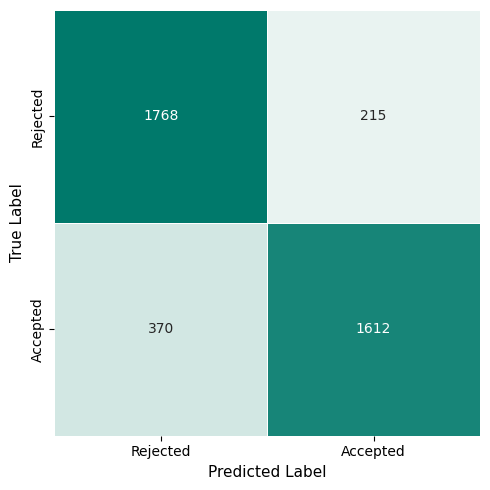

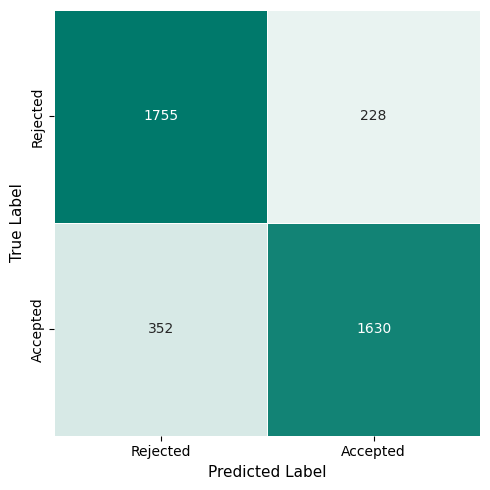

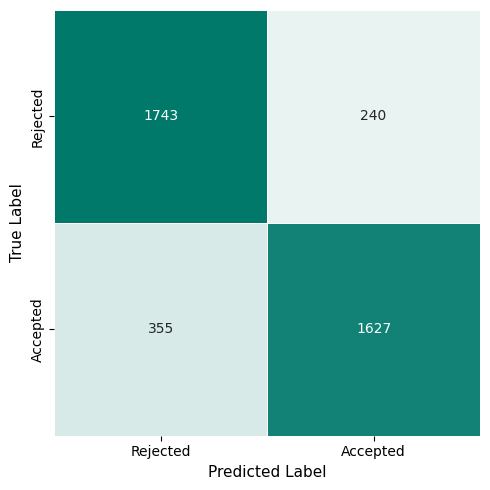

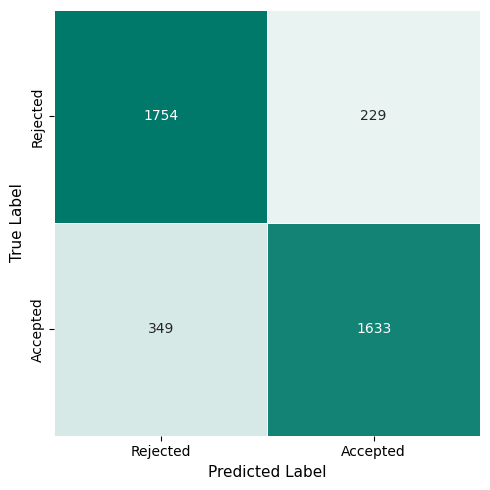

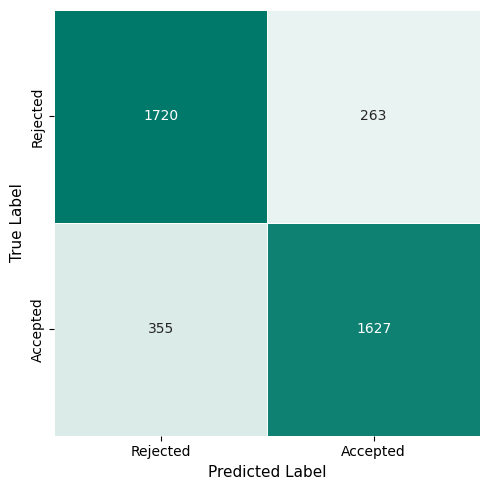

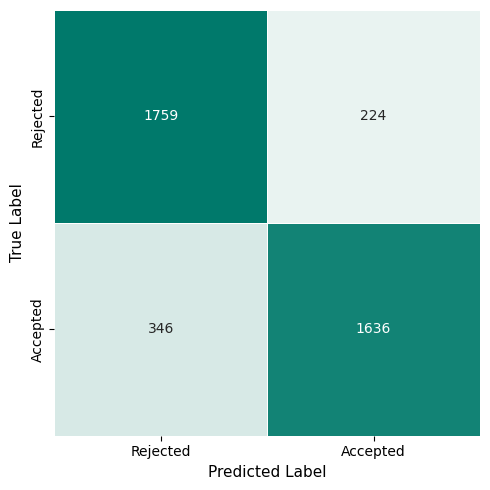

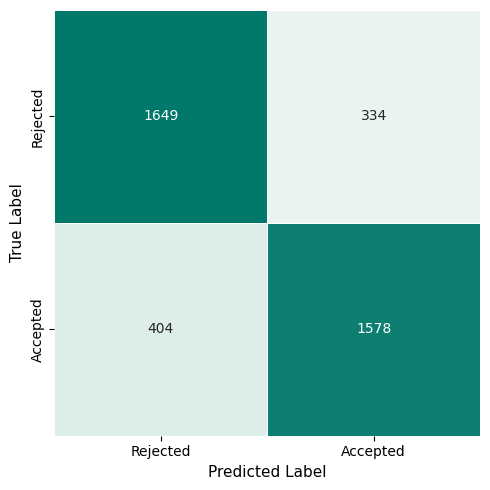

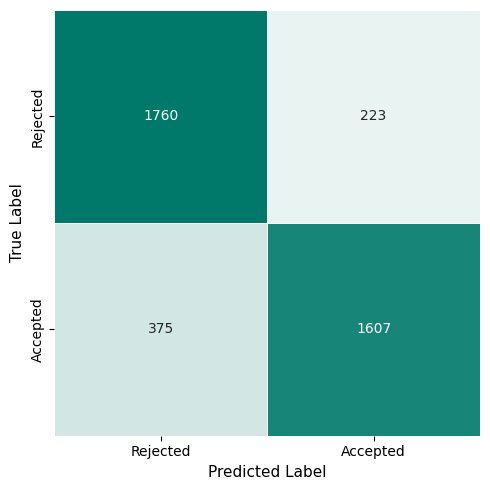

In [ ]:
def map_if_numeric(series):
    if pd.api.types.is_numeric_dtype(series):
        return series.map({0: 'Rejected', 1: 'Accepted'})
    return series

green_colors = sns.light_palette("#00796B", as_cmap=True)


for method in methods:
    y_true = map_if_numeric(df["Encoded_Label"])
    y_pred = map_if_numeric(df[f"Predicted_Label_{method}"])

    cm = confusion_matrix(y_true, y_pred, labels=class_labels)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=green_colors,
        xticklabels=class_labels,
        yticklabels=class_labels,
        cbar=False,
        linewidths=0.5,
        linecolor='white',
        square=True
    )

    plt.xlabel("Predicted Label", fontsize=11)
    plt.ylabel("True Label", fontsize=11)

    plt.tight_layout()
    plt.savefig(f"{method}_confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

### How much misclassified from the total number?

In [ ]:
type_mapping = {
    'نظر الدعوى': 'Proceedings of the case',
    'الاجاره': 'Renting',
    'البيع': 'Selling'
}

df["Mapped_Type"] = df["Type"].map(type_mapping).fillna(df["Type"])


cols = 4
rows = int(np.ceil(len(methods) / cols))
fig = make_subplots(rows=rows, cols=cols, subplot_titles=methods)

row, col = 1, 1
for method in methods:
    pred_col = f"Predicted_Label_{method}"
    if pred_col not in df.columns:
        print(f"Skipping {method}, column not found")
        continue


    wrong_preds = df[df["Encoded_Label"] != df[pred_col]].copy()


    type_counts = wrong_preds["Mapped_Type"].value_counts().reset_index()
    type_counts.columns = ["Type", "Count"]

    fig.add_trace(
        go.Bar(
            x=type_counts["Type"],
            y=type_counts["Count"],
            text=type_counts["Count"],
            textposition="auto",
            marker_color='steelblue'
        ),
        row=row, col=col
    )

    col += 1
    if col > cols:
        col = 1
        row += 1


fig.update_layout(
    height=300 * rows,
    width=1000,
    title_text="Misclassified Document Types per Aggregation Method",
    showlegend=False
)

fig.show()

In [ ]:
total_counts = df["Mapped_Type"].value_counts().to_dict()


cols = 4
rows = int(np.ceil(len(methods) / cols))
fig = make_subplots(rows=rows, cols=cols, subplot_titles=methods)

row, col = 1, 1
for method in methods:
    pred_col = f"Predicted_Label_{method}"
    if pred_col not in df.columns:
        print(f"Skipping {method}, missing column")
        continue


    wrong_preds = df[df["Encoded_Label"] != df[pred_col]].copy()
    wrong_preds["Mapped_Type"] = wrong_preds["Type"].map(type_mapping).fillna(wrong_preds["Type"])


    wrong_counts = wrong_preds["Mapped_Type"].value_counts().reset_index()
    wrong_counts.columns = ["Type", "Wrong_Count"]


    wrong_counts["Total_Count"] = wrong_counts["Type"].map(total_counts)
    wrong_counts = wrong_counts[wrong_counts["Total_Count"] > 0]
    wrong_counts["Percent"] = (wrong_counts["Wrong_Count"] / wrong_counts["Total_Count"]) * 100


    fig.add_trace(
        go.Bar(
            x=wrong_counts["Type"],
            y=wrong_counts["Percent"],
            text=wrong_counts["Percent"].round(1).astype(str) + "%",
            textposition="auto",
            marker_color="steelblue"
        ),
        row=row, col=col
    )

    col += 1
    if col > cols:
        col = 1
        row += 1


fig.update_layout(
    height=300 * rows,
    width=1000,
    title_text="Misclassification Rate (% of Total per Type) by Aggregation Method",
    showlegend=False
)

fig.show()

In [ ]:
df["Mapped_Type"] = df["Type"].map(type_mapping).fillna(df["Type"])
all_type_counts = df["Mapped_Type"].value_counts().reset_index()
all_type_counts.columns = ["Type", "Total_Documents"]
total_type_dict = all_type_counts.set_index("Type")["Total_Documents"].to_dict()


for method in methods:
    pred_col = f"Predicted_Label_{method}"
    if pred_col not in df.columns:
        continue


    misclassified_df = df[df["Encoded_Label"] !=df[pred_col]].copy()
    misclassified_df["Mapped_Type"] = misclassified_df["Type"].map(type_mapping).fillna(misclassified_df["Type"])


    misclassified_type_counts = misclassified_df["Mapped_Type"].value_counts().reset_index()
    misclassified_type_counts.columns = ["Type", "Misclassified_Documents"]


    comparison_df = pd.merge(all_type_counts, misclassified_type_counts, on="Type", how="left")
    comparison_df["Misclassified_Documents"] = comparison_df["Misclassified_Documents"].fillna(0).astype(int)
    comparison_df["Misclassification_%"] = (
        comparison_df["Misclassified_Documents"] / comparison_df["Total_Documents"] * 100
    )


    fig = px.bar(
        comparison_df,
        x="Type",
        y=["Total_Documents", "Misclassified_Documents"],
        barmode="group",
        title=f"Total vs. Misclassified Documents by Type — {method}",
        labels={"value": "Document Count", "variable": "Category"},
        text_auto=True
    )
    fig.update_layout(xaxis_tickangle=-45, height=400, width=650)
    fig.show()

In [ ]:
comparison_df["Misclassification_%_Formatted"] = (
    comparison_df["Misclassification_%"].round(0).astype(int).astype(str) + "%"
)


fig = px.bar(
    comparison_df,
    x="Type",
    y="Misclassification_%",
    title="Misclassification Rate by Type (%)",
    labels={"Misclassification_%": "Error Rate (%)"},
    text="Misclassification_%_Formatted",
    color_discrete_sequence=["#4a90e2"]  # consistent blue
)


fig.update_layout(
    xaxis_tickangle=-30,
    yaxis_tickformat=".0f",
    uniformtext_minsize=8,
    uniformtext_mode='show',
    showlegend=False,
    height=500,
    margin=dict(t=80),
    yaxis=dict(range=[0, comparison_df["Misclassification_%"].max() + 5])
)


fig.update_traces(textposition="outside")
fig.show()

In [ ]:
fig2 = px.histogram(
    df,
    x="Num_Segments",
    nbins=df["Num_Segments"].max(),
    title="Segment Count in Misclassified Documents",
    labels={"Num_Segments": "Number of Segments", "count": "Number of Documents"}
)
fig2.update_layout(bargap=0.2)
fig2.show()

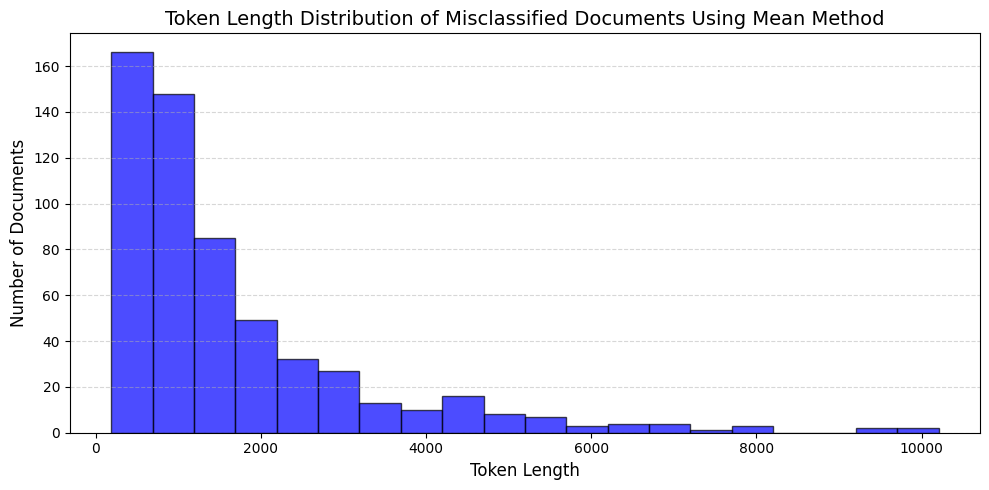

In [ ]:
method = "mean"

wrong_docs = test_df_result[test_df_result["Encoded_Label"] != test_df_result[f"Predicted_Label_{method}"]]

reconstructed_facts = test_texts.groupby("Document_ID")["Segmented_Facts"].apply(lambda segs: " ".join(segs)).reset_index()
reconstructed_facts.columns = ["Document_ID", "Full_Fact"]

wrong_docs = pd.merge(wrong_docs, reconstructed_facts, on="Document_ID", how="left")

token_counts = [len(tokenizer.encode(text, truncation=False)) for text in wrong_docs["Full_Fact"].dropna()]

plt.figure(figsize=(10, 5))
plt.hist(token_counts, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Token Length", fontsize=12)
plt.ylabel("Number of Documents", fontsize=12)
plt.title("Token Length Distribution of Misclassified Documents Using Mean Method", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

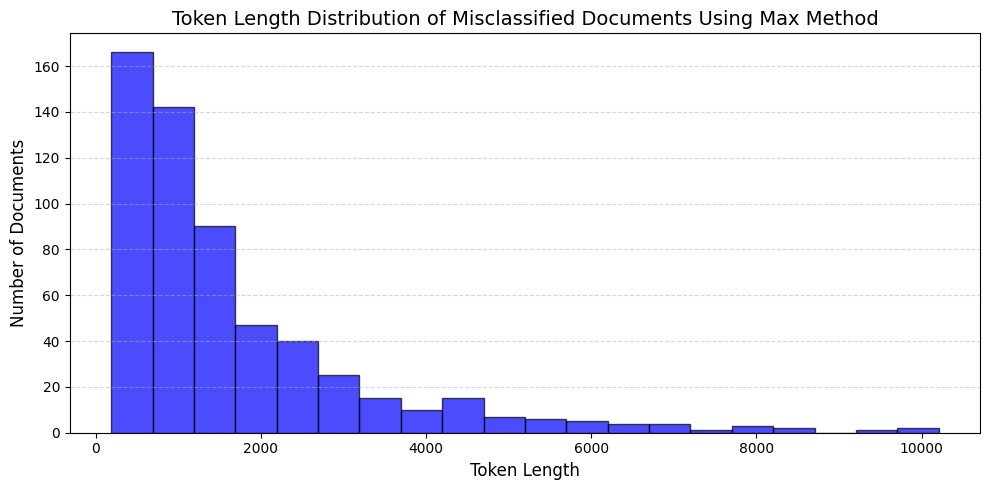

In [ ]:
method = "max"

wrong_docs = test_df_result[test_df_result["Encoded_Label"] != test_df_result[f"Predicted_Label_{method}"]]

reconstructed_facts = test_texts.groupby("Document_ID")["Segmented_Facts"].apply(lambda segs: " ".join(segs)).reset_index()
reconstructed_facts.columns = ["Document_ID", "Full_Fact"]

wrong_docs = pd.merge(wrong_docs, reconstructed_facts, on="Document_ID", how="left")


token_counts = [len(tokenizer.encode(text, truncation=False)) for text in wrong_docs["Full_Fact"].dropna()]


plt.figure(figsize=(10, 5))
plt.hist(token_counts, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Token Length", fontsize=12)
plt.ylabel("Number of Documents", fontsize=12)
plt.title("Token Length Distribution of Misclassified Documents Using Max Method", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

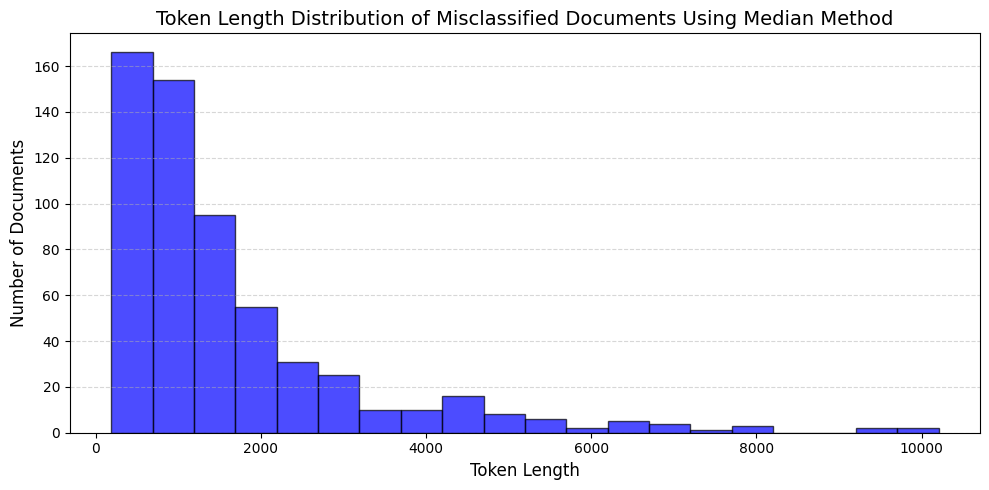

In [ ]:
method = "median"

wrong_docs = test_df_result[test_df_result["Encoded_Label"] != test_df_result[f"Predicted_Label_{method}"]]

reconstructed_facts = test_texts.groupby("Document_ID")["Segmented_Facts"].apply(lambda segs: " ".join(segs)).reset_index()
reconstructed_facts.columns = ["Document_ID", "Full_Fact"]


wrong_docs = pd.merge(wrong_docs, reconstructed_facts, on="Document_ID", how="left")


token_counts = [len(tokenizer.encode(text, truncation=False)) for text in wrong_docs["Full_Fact"].dropna()]


plt.figure(figsize=(10, 5))
plt.hist(token_counts, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Token Length", fontsize=12)
plt.ylabel("Number of Documents", fontsize=12)
plt.title("Token Length Distribution of Misclassified Documents Using Median Method", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
if "Full_Fact" not in test_df_result.columns:
    reconstructed_facts = test_texts.groupby("Document_ID")["Segmented_Facts"].apply(lambda segs: " ".join(segs)).reset_index()
    reconstructed_facts.columns = ["Document_ID", "Full_Fact"]
    test_df_result = pd.merge(test_df_result, reconstructed_facts, on="Document_ID", how="left")


if "Token_Count" not in test_df_result.columns:
    test_df_result["Token_Count"] = test_df_result["Full_Fact"].apply(lambda text: len(tokenizer.encode(str(text), truncation=False)))


methods = ["mean", "max", "median", "top3_mean", "length_weighted", "confidence_weighted", "positional_early", "positional_late"]

In [ ]:
for method in methods:
    test_df_result["Is_Correct"] = test_df_result["Encoded_Label"] == test_df_result[f"Predicted_Label_{method}"]


    fig = px.histogram(
        test_df_result,
        x="Token_Count",
        color="Is_Correct",
        nbins=20,
        barmode="group",
        color_discrete_map={True: "#1f77b4", False: "#d62728"},
        title=f"Token Length Distribution: Correct vs Incorrect Predictions ({method} aggregation)",
        labels={"Token_Count": "Number of Tokens", "Is_Correct": "Prediction Correct?"},
        opacity=0.8
    )

    fig.update_layout(
        height=500,
        bargap=0.1,
        legend_title_text="Prediction",
        font=dict(size=14)
    )

    fig.show()

In [ ]:
for method in aggregation_methods:
    df["Is_Correct"] = df["Encoded_Label"] == df[f"Predicted_Label_{method}"]


    df[f"True_Confidence_{method}"] =df.apply(
        lambda row: row[f"Confidence_{method}"] if row[f"Predicted_Label_{method}"] == 1 else 1 - row[f"Confidence_{method}"],
        axis=1
    )


    avg_conf = df.groupby("Is_Correct")[f"True_Confidence_{method}"].mean().round(3)

    print(f"\n Average Prediction Confidence ({method} aggregation):")
    print(avg_conf)



 Average Prediction Confidence (mean aggregation):
Is_Correct
False    0.696
True     0.865
Name: True_Confidence_mean, dtype: float64

 Average Prediction Confidence (max aggregation):
Is_Correct
False    0.699
True     0.865
Name: True_Confidence_max, dtype: float64

 Average Prediction Confidence (median aggregation):
Is_Correct
False    0.703
True     0.866
Name: True_Confidence_median, dtype: float64

 Average Prediction Confidence (top3_mean aggregation):
Is_Correct
False    0.721
True     0.877
Name: True_Confidence_top3_mean, dtype: float64

 Average Prediction Confidence (length_weighted aggregation):
Is_Correct
False    0.706
True     0.863
Name: True_Confidence_length_weighted, dtype: float64

 Average Prediction Confidence (confidence_weighted aggregation):
Is_Correct
False    0.714
True     0.874
Name: True_Confidence_confidence_weighted, dtype: float64

 Average Prediction Confidence (positional_early aggregation):
Is_Correct
False    0.716
True     0.864
Name: True_Conf

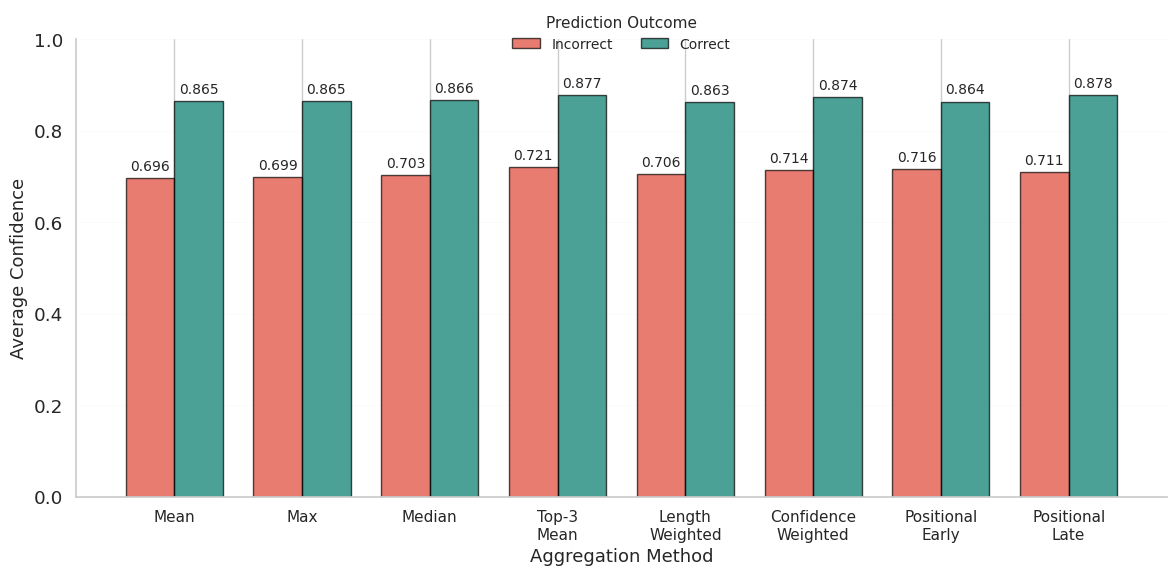

In [ ]:
aggregation_methods = [
    "mean","max","median","top3_mean",
    "length_weighted","confidence_weighted",
    "positional_early","positional_late"
]
labels_multiline = [
    "Mean","Max","Median","Top-3\nMean",
    "Length\nWeighted","Confidence\nWeighted",
    "Positional\nEarly","Positional\nLate"
]


results = {}
for method in aggregation_methods:
    is_correct = df["Encoded_Label"] == df[f"Predicted_Label_{method}"]
    true_conf = np.where(df[f"Predicted_Label_{method}"] == 1,
                         df[f"Confidence_{method}"],
                         1 - df[f"Confidence_{method}"])


    inc_vals = true_conf[~is_correct]
    cor_vals = true_conf[ is_correct]
    mean_inc = float(np.mean(inc_vals)) if inc_vals.size else np.nan
    mean_cor = float(np.mean(cor_vals)) if cor_vals.size else np.nan

    results[method] = {"Incorrect": mean_inc, "Correct": mean_cor}


means_inc = np.array([results[m]["Incorrect"] for m in aggregation_methods], dtype=float)
means_cor = np.array([results[m]["Correct"]   for m in aggregation_methods], dtype=float)


x = np.arange(len(aggregation_methods))
w = 0.38

fig, ax = plt.subplots(figsize=(12, 6))

b1 = ax.bar(x - w/2, means_inc, width=w, color="#E14434",
            edgecolor="black", alpha=0.7, label="Incorrect")
b2 = ax.bar(x + w/2, means_cor, width=w, color="#00796B",
            edgecolor="black", alpha=0.7, label="Correct")


for bars in (b1, b2):
    for rect in bars:
        h = rect.get_height()
        if np.isfinite(h):
            ax.text(rect.get_x() + rect.get_width()/2, h + 0.01, f"{h:.3f}",
                    ha="center", va="bottom", fontsize=10)


ax.set_xticks(x)
ax.set_xticklabels(labels_multiline, fontsize=11)
ax.set_ylabel("Average Confidence", fontsize=13)
ax.set_xlabel("Aggregation Method", fontsize=13)
ax.set_ylim(0.0, 1.0)
ax.yaxis.grid(True, color="lightgray", alpha=0.07, linewidth=0.7)
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


ax.legend(title="Prediction Outcome", loc="upper center",
          bbox_to_anchor=(0.5, 1.08), ncol=2, frameon=False,
          fontsize=10, title_fontsize=11)

fig.savefig("Avg_confidence_per_method.png", dpi=300, bbox_inches="tight")
fig.tight_layout()
plt.show()


In [ ]:
doc_df = df.copy()

methods = [col for col in doc_df.columns if col.startswith("Predicted_Label_")]
melted = pd.melt(
    doc_df,
    id_vars=["Document_ID", "Encoded_Label", "Type"],
    value_vars=methods,
    var_name="Method",
    value_name="Predicted_Label"
)

melted["Method"] = melted["Method"].str.replace("Predicted_Label_", "")

melted["Correct"] = melted["Encoded_Label"] == melted["Predicted_Label"]

accuracy_by_type_method = melted.groupby(["Type", "Method"])["Correct"].mean().reset_index()
accuracy_by_type_method["Correct"] = accuracy_by_type_method["Correct"].round(2)

In [ ]:
doc_df = df.copy()


methods = [col for col in doc_df.columns if col.startswith("Predicted_Label_")]
melted = pd.melt(
    doc_df,
    id_vars=["Document_ID", "Encoded_Label", "Type"],
    value_vars=methods,
    var_name="Method",
    value_name="Predicted_Label"
)

melted["Method"] = melted["Method"].str.replace("Predicted_Label_", "")

melted["Correct"] = melted["Encoded_Label"] == melted["Predicted_Label"]

accuracy_by_type_method = melted.groupby(["Type", "Method"])["Correct"].mean().reset_index()
accuracy_by_type_method["Correct"] = accuracy_by_type_method["Correct"].round(2)

In [ ]:
type_mapping = {
    'نظر الدعوى': 'Proceedings of the case',
    'الاجاره': 'Renting',
    'البيع': 'Selling',
}

accuracy_by_type_method["Type"] = accuracy_by_type_method["Type"].map(type_mapping).fillna(accuracy_by_type_method["Type"])

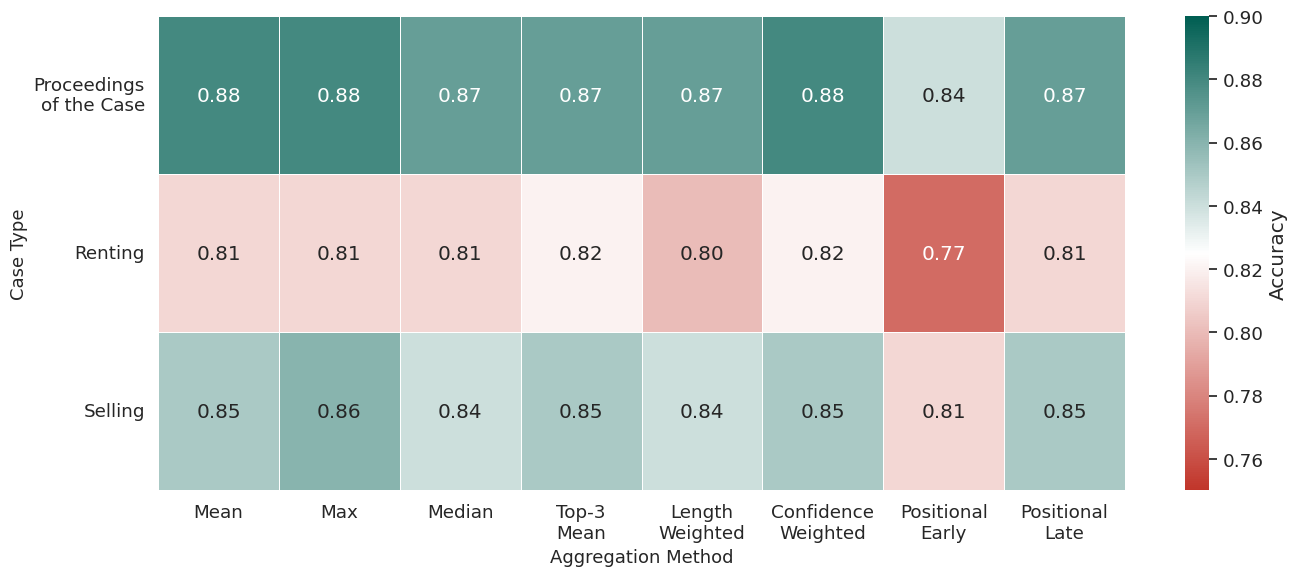

In [ ]:
heatmap_df = accuracy_by_type_method.pivot(index="Type", columns="Method", values="Correct")


method_order = [
    "mean","max","median","top3_mean",
    "length_weighted","confidence_weighted",
    "positional_early","positional_late"
]
method_map = {
    "mean": "Mean",
    "max": "Max",
    "median": "Median",
    "top3_mean": "Top-3\nMean",
    "length_weighted": "Length\nWeighted",
    "confidence_weighted": "Confidence\nWeighted",
    "positional_early": "Positional\nEarly",
    "positional_late": "Positional\nLate",
}
type_map = {"Proceedings of the case": "Proceedings\nof the Case"}


cols = [m for m in method_order if m in heatmap_df.columns]
heatmap_df = heatmap_df.loc[:, cols]
heatmap_df.columns = [method_map.get(c, c) for c in heatmap_df.columns]
heatmap_df = heatmap_df.rename(index=type_map)


TEAL_DARK = "#005E52"
RED_DARK  = "#C1352A"
cmap = sns.blend_palette([RED_DARK, "#FFFFFF", TEAL_DARK], as_cmap=True)


vmin, vmax = 0.75, 0.90
norm = TwoSlopeNorm(vmin=vmin, vcenter=(vmin + vmax) / 2, vmax=vmax)


plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    heatmap_df, annot=True, fmt=".2f",
    cmap=cmap, norm=norm,
    linewidths=0.5, linecolor="white",
    cbar_kws={"label": "Accuracy"}
)


ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel("Aggregation Method", fontsize=13)
plt.ylabel("Case Type", fontsize=13)
plt.tight_layout()
plt.savefig("Methods_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
fig = px.bar(
    accuracy_by_type_method.copy().assign(
        Type=lambda df: df["Type"].map(type_mapping).fillna(df["Type"])
    ),
    x="Method",
    y="Correct",
    facet_col="Type",
    text="Correct",
    title="Accuracy per Aggregation Method (Split by Type)",
    labels={"Correct": "Accuracy"},
    color="Method"
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', height=500)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

In [ ]:
selected_methods = ["mean", "max", "median"]
filtered_df = accuracy_by_type_method[accuracy_by_type_method["Method"].isin(selected_methods)]

filtered_df = filtered_df.copy().assign(
    Type=lambda df: df["Type"].map(type_mapping).fillna(df["Type"])
)

fig = px.bar(
    filtered_df,
    x="Method",
    y="Correct",
    facet_col="Type",
    text="Correct",
    title="Accuracy per Aggregation Method (Split by Type)",
    labels={"Correct": "Accuracy"},
    color="Method"
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', height=500)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()


In [ ]:
gap_df = conf_df.pivot(index="Method", columns="Is_Correct", values="Average_Confidence").reset_index()
gap_df["Confidence_Gap"] = (gap_df["Correct"] - gap_df["Incorrect"]).round(3)

fig = px.bar(
    gap_df,
    x="Method",
    y="Confidence_Gap",
    text="Confidence_Gap",
    title="Confidence Gap Between Correct and Incorrect Predictions (Top Methods)",
    labels={"Confidence_Gap": "Confidence Gap"},
    color_discrete_sequence=["#4a90e2"]
)
fig.update_traces(texttemplate='%{text:.3f}', textposition="outside")
fig.update_layout(height=400, font=dict(size=13))
fig.show()


/tmp/ipython-input-2842446494.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_group = df.groupby("Length_Bin")["Is_Correct"].mean().reset_index()


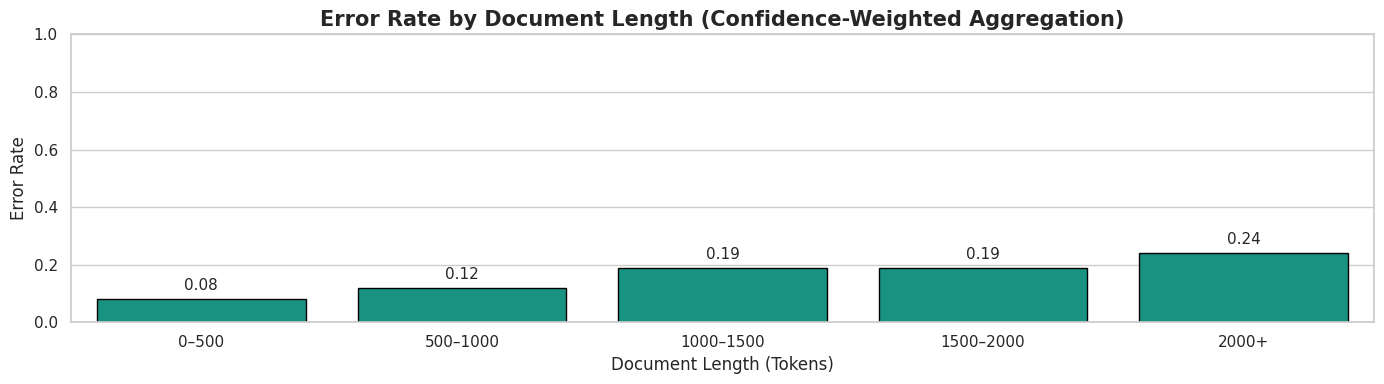

In [ ]:
df["Length_Bin"] = pd.cut(df["Token_Count"],
                          bins=[0, 500, 1000, 1500, 2000, float('inf')],
                          labels=["0–500", "500–1000", "1000–1500", "1500–2000", "2000+"])

method = "confidence_weighted"
df["Is_Correct"] = df["Encoded_Label"] == df[f"Predicted_Label_{method}"]

length_group = df.groupby("Length_Bin")["Is_Correct"].mean().reset_index()
length_group["Error_Rate"] = (1 - length_group["Is_Correct"]).round(2)


sns.set(style="whitegrid")
plt.figure(figsize=(14, 4))
barplot = sns.barplot(data=length_group, x="Length_Bin", y="Error_Rate",
                      color="#03A791", edgecolor="black")


for i, row in length_group.iterrows():
    plt.text(i, row["Error_Rate"] + 0.02, f"{row['Error_Rate']:.2f}",
             ha='center', va='bottom', fontsize=11)


plt.title("Error Rate by Document Length (Confidence-Weighted Aggregation)", fontsize=15, weight='bold')
plt.xlabel("Document Length (Tokens)", fontsize=12)
plt.ylabel("Error Rate", fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
test_df_result.to_csv("final_test_results.csv", index=False)
val_df_result.to_csv("final_val_results.csv", index=False)
train_df_result.to_csv("final_train_results.csv", index=False)

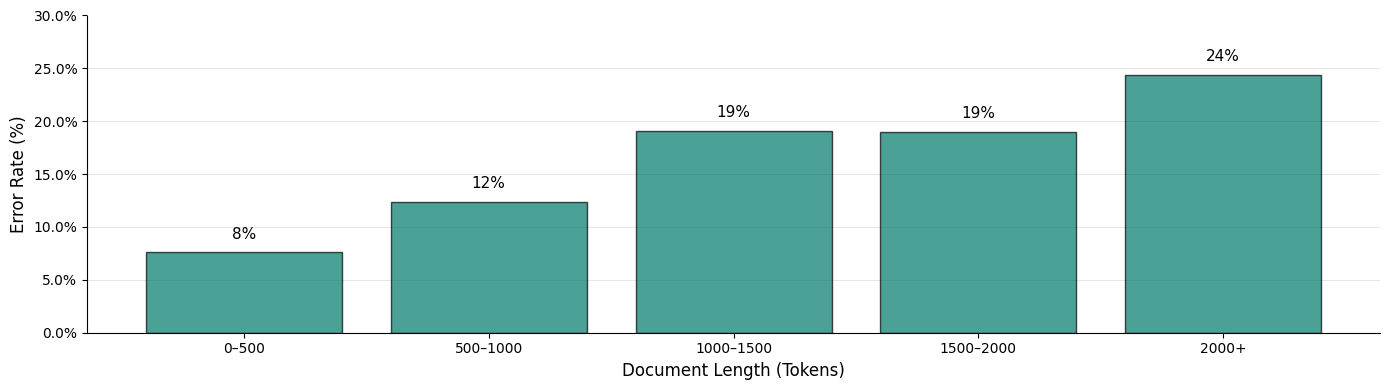

In [ ]:
df["Length_Bin"] = pd.cut(
    df["Token_Count"],
    bins=[0, 500, 1000, 1500, 2000, float('inf')],
    labels=["0–500", "500–1000", "1000–1500", "1500–2000", "2000+"]
)

method = "confidence_weighted"
df["Is_Correct"] = df["Encoded_Label"] == df[f"Predicted_Label_{method}"]

length_group = df.groupby("Length_Bin", observed=True)["Is_Correct"].mean().reset_index()
length_group["Error_Rate"] = (1 - length_group["Is_Correct"]).round(3)

fig, ax = plt.subplots(figsize=(14, 4))

bars = ax.bar(
    length_group["Length_Bin"].astype(str),
    length_group["Error_Rate"],
    alpha=0.7,
    color="#00796B",
    edgecolor="black"
)

for i, row in length_group.iterrows():
    ax.text(
        i,
        row["Error_Rate"] + 0.01,
        f"{row['Error_Rate']*100:.0f}%",
        ha='center', va='bottom', fontsize=11
    )

ax.set_xlabel("Document Length (Tokens)", fontsize=12)
ax.set_ylabel("Error Rate (%)", fontsize=12)
ax.set_ylim(0, 0.3)


ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.yaxis.grid(True, linestyle='-', linewidth=0.7, alpha=0.6, color='lightgray')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

fig.savefig("Error_Rate_Confidence_Weighted.png", dpi=300, bbox_inches='tight')
plt.show()